# <center> Online-NST, Алгоритм Гатиса </center>

![](online-nst.png)

# Содержание
## 1. [Свёрточная нейросеть для извлечения признаков](#section1)
## 2. [Слои лоссов](#section2)
## 3. [Слой нормализации](#section3)
## 4. [Класс модели переноса стиля](#section4)
## 5. [Тестирование бейзлайн решения](#section5)
- ### [5.1. Загрузка тестовых данных](#section5.1)
- ### [5.2. Функция эксперимента](#section5.2)
- ### [5.3. Запуск бейзлайн решения. Оценка и сохранение результатов](#section5.3)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from torchvision.models import vgg19

from PIL import Image

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_device(device)
device

device(type='cpu')

## <a id="section1"> </a> 1. Свёрточная нейросеть для извлечения признаков

Возьмём первые 11 слоев предобученной VGG19, среди которых 5 свёрток, и заморозим их, так как оптимизировать их параметры мы не собираемся.

In [4]:
base_cnn = vgg19(pretrained=True).features[0 : 11].to(device)

for param in base_cnn.parameters():
    param.requires_grad = False

base_cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## <a id="section2"> </a> 2. Слои лоссов

Для рассчёта функции потерь добавим слои для потери контента и потери стиля.

In [5]:
class ContentLoss(nn.Module):
    """
    Потеря контента - это просто MSELoss между картами признаков 
    стилизации и исходного изображения с контентом.
    """
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach().to(device)
        
    def forward(self, inp):
        self.loss = F.mse_loss(inp, self.target).to(device)
        return inp
    

class StyleLoss(nn.Module):
    """
    Потеря стиля - это MSELoss между матрицами Грамма для 
    карт признаков стилизации и исходного изображения со стилем.
    """
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = StyleLoss.gram_matrix(target).detach().to(device)
        
    @staticmethod
    def gram_matrix(inp):
        batch_size, nmaps, w, h = inp.size()
    
        features = inp.view(batch_size * nmaps, w * h) # Получаем для каждой карты признаков вектор размера wxh
    
        G = torch.mm(features, features.T)
    
        return G.div(batch_size * nmaps * w * h)

    
    def forward(self, inp):
        G = StyleLoss.gram_matrix(inp).to(device)
        self.loss = F.mse_loss(G, self.target).to(device)
        return inp

## <a id="section3"> </a> 3. Слой нормализации

In [6]:
# VGG обучалась на картинках с определенными средним значением и средним стандратным отклонением.
# Поэтому нужно приводить свои изображение к примерно такому же распределению.

VGG19_NORMALIZATION_MEAN = torch.tensor([0.485, 0.456, 0.406])
VGG19_NORMALIZATION_STD = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean=VGG19_NORMALIZATION_MEAN,
                 std=VGG19_NORMALIZATION_STD):
       super(Normalization, self).__init__()
       self.mean = torch.tensor(mean).view(-1, 1, 1)
       self.std = torch.tensor(std).view(-1, 1, 1)
   
    def forward(self, img):
       return (img - self.mean) / self.std

## <a id="section4"> </a> 4. Функция-конструктор модели переноса стиля

In [8]:
CONTENT_LAYERS_DEFAULT = ['Conv_4'] # после этих слоев будет вставлен модуль потери контента
STYLE_LAYERS_DEFAULT = ['Conv_1', 'Conv_2', 'Conv_3', 'Conv_4', 'Conv_5'] # после этих слоев будет вставлен модуль потери стиля

In [9]:
class StyleModel:
    """
    Класс-интерфейс переноса стиля.
    """
    def __init__(self, base_cnn, content_img, style_img, 
                 normalization_mean=VGG19_NORMALIZATION_MEAN, 
                 normalization_std=VGG19_NORMALIZATION_STD, 
                 content_layers=CONTENT_LAYERS_DEFAULT, 
                 style_layers=STYLE_LAYERS_DEFAULT):
        
        content_img = content_img.to(device)
        style_img = style_img.to(device)
        self.model = nn.Sequential().to(device) # модель, состоящая из слоев VGG19 и модулей лоссов, 
                                                # которые встраиваются между слоями VGG19
        self.content_losses = [] # здесь будут лежать ссылки на модули потери контента
        self.style_losses = [] # здесь будут лежать ссылки на модули потери стиля
        
        self.model.add_module("ImageNorm", Normalization(mean=normalization_mean, std=normalization_std).to(device))

        conv_counter: int = 0
        module_name: str = ""

        # перебираем все слои vgg19
        for layer in base_cnn.children():
            if isinstance(layer, nn.Conv2d):
                conv_counter += 1
                module_name = f"Conv_{conv_counter}"
                
            elif isinstance(layer, nn.ReLU):
                module_name = f"ReLU_{conv_counter}"
                layer = nn.ReLU(inplace=False)
                
            elif isinstance(layer, nn.MaxPool2d):
                module_name = f"MaxPool2d_{conv_counter}"
            
            else:
                raise ValueError # Мы не ожидаем никаких других типов модулей кроме как Conv2d, MaxPool2d и ReLU,
                                 # так как VGG19 по умолчанию содержит только их. Для стилизации BatchNorm вреден.
            
            self.model.add_module(module_name, layer.to(device))

            if module_name in content_layers:
                target = self.model(content_img).detach().to(device)
                content_loss_module = ContentLoss(target)
                self.content_losses.append(content_loss_module)
                self.model.add_module(f"ContentLoss_{conv_counter}", content_loss_module)
                
            if module_name in style_layers:
                target = self.model(style_img).detach().to(device)
                style_loss_module = StyleLoss(target)
                self.style_losses.append(style_loss_module)
                self.model.add_module(f"StyleLoss_{conv_counter}", style_loss_module)
                
        self.model.to(device)

    
    def __repr__(self):
        return f'{self.__class__.__name__}(model = {self.model})'


    def transfer_style(self, input_image, optimizer_class=None, lr=0.05, 
                       num_steps=300, style_weight=100000, content_weight=1, scheduler_step:int|None=None, gamma=1.0, print_logs:int|None=None):
        """
        Параметры:
        * scheduler_step: как часто(количество итераций) уменьшать learning_rate. Если None, то learning_rate не меняется
        """
        input_image = input_image.to(device) # оптимизироваться будет этот тензор
        
        input_image.requires_grad = True
        self.model.eval()

        # Для возможности перебирать разные оптимизаторы
        optimizer = None
        if not optimizer_class:
            optimizer = optim.Adam([input_image], lr=lr)
        else:
            optimizer = optimizer_class([input_image], lr=lr)

        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma) 

        
        for i in range(1, num_steps + 1):
            
            def closure():
                optimizer.zero_grad()

                self.model(input_image)
                content_final_loss = 0.0
                style_final_loss = 0.0
            
                for content_loss in self.content_losses:
                    content_final_loss += content_loss.loss

                for style_loss in self.style_losses:
                    style_final_loss += style_loss.loss

                loss = content_weight * content_final_loss + style_weight * style_final_loss
                loss.backward()

                return loss
                
            optimizer.step(closure)

            if scheduler_step:
                if i % scheduler_step == 0:
                    scheduler.step()
            
            with torch.no_grad():
                input_image.clamp_(0, 1)

            if print_logs:
                if i % print_logs == 0:
                    print(f"Эпоха номер {i + 1}")
                    plt.imshow(ToPILImage()(input_image[0]))
                    plt.show()
                
        with torch.no_grad():
            input_image.clamp_(0, 1)
            
        return input_image

## <a id="section5"> </a>5. Тестирование бейзлайн решения

### <a id="section5.1"> </a> 5.1. Загрузка тестовых данных

In [12]:
import os
import random

random.seed(42)

IMSIZE = (256, 256)

contents_directory = "../test-data/contents/"
styles_directory = "../test-data/styles/"

content_names = os.listdir(contents_directory) 
style_names = os.listdir(styles_directory)

content_images = [Image.open(contents_directory + filename).resize(IMSIZE) for filename in content_names]
style_images = [Image.open(styles_directory + filename).resize(IMSIZE) for filename in style_names]

# Для тестирования возьмём случайную выборку из тестовых изображений (для начала).
random.shuffle(content_images)
random.shuffle(style_images)

content_images = content_images[:10]
style_images = style_images[:10]

### <a id="section5.2"> </a> 5.2. Функция эксперимента

In [13]:
import time
import matplotlib.pyplot as plt

In [14]:
def experiment(base_model, content_images, style_images, 
               optimizer, lr: float, num_steps: int,
               scheduler_step: int, gamma: float,
               content_weight: int, style_weight: int, 
               content_layers: list[str], style_layers: list[str], 
               noisy_input: bool = False, print_logs: int | None = None) -> dict[str, float]:
    """
    Стилизует набор картинок по набору стилей. Одному контенту - один стиль. Количество контента и стиля должно быть одинаковым.
    Считает среднее время генерации стилизации и средние потери стиля и контента.
    Parameters:
        * base_model - слои свёрточной NN (nn.Sequential)
        * content_images - список изображений PIL.Image
        * style_images - список стилей PIL.Image
        * scheduler_step - число, через какое количество эпох менять lr
        * gamma - число, на которое lr умножается раз scheduler_step эпох
        * content_weight, style_weight - веса потерь контента и стиля
        * content_layers, style_layers - слои, после которых вставляются слои лоссов
        * noisy_input - True/False, инициализировать выходное изображение шумом (True) или как копию content_image (False)
    """
    results: dict[str, float] = {
        "avg_time": 0.0, 
        "content_score": 0.0,
        "style_score": 0.0
    }
    
    iteration_counter = 0
    total_time_spent_on_transfering = 0.0

    total_content_score = 0.0
    total_style_score = 0.0

    for content_img, style_img in zip(content_images, style_images):
        start = time.time()
            
        content = ToTensor()(content_img)[:3].unsqueeze(0)
        style = ToTensor()(style_img)[:3].unsqueeze(0)
        
        input_ = torch.randn(content.data.size()) if noisy_input else content.clone()
            
        style_model = StyleModel(
            base_cnn=base_model,
            content_img=content,
            style_img=style,
            content_layers=content_layers,
            style_layers=style_layers
        )

        output = style_model.transfer_style(
            input_image=input_,
            optimizer_class=optimizer,
            lr=lr,
            num_steps=num_steps,
            scheduler_step=scheduler_step,
            gamma=gamma,
            content_weight=content_weight,
            style_weight=style_weight,
            print_logs=print_logs
        )
            
        end = time.time()
        total_time_spent_on_transfering += end - start
        iteration_counter += 1

        with torch.no_grad():
            total_content_score += F.mse_loss(output.to(device), content.to(device)).item()
            style_loss = StyleLoss(style)
            style_loss(output)
            total_style_score += style_loss.loss.item()

        fig, axes = plt.subplots(1, 3, figsize=(10, 14))
        axes[0].set_title("Content")
        axes[1].set_title("Style")
        axes[2].set_title("Result")
        axes[0].imshow(content_img)
        axes[1].imshow(style_img)
        axes[2].imshow(ToPILImage()(output[0]))
        plt.show()
            
    results["avg_time"] = total_time_spent_on_transfering / iteration_counter
    results["content_score"] = total_content_score / iteration_counter
    results["style_score"] = total_style_score / iteration_counter
    
    return results

### <a id="section5.3"> </a> 5.3. Запуск бейзлайн решения. Оценка и сохранение результатов.

In [15]:
import mlflow

In [16]:
ONLINE_NST_MLFLOW = "/home/maksim/Repos/style-transfer/materials/online-nst/mlruns/"

mlflow.set_tracking_uri(ONLINE_NST_MLFLOW)
mlflow.set_experiment("Online-NST Baseline")

<Experiment: artifact_location='/home/maksim/Repos/style-transfer/materials/online-nst/experiments/mlruns/409642611399561252', creation_time=1742381944787, experiment_id='409642611399561252', last_update_time=1742381944787, lifecycle_stage='active', name='Online-NST Baseline', tags={}>

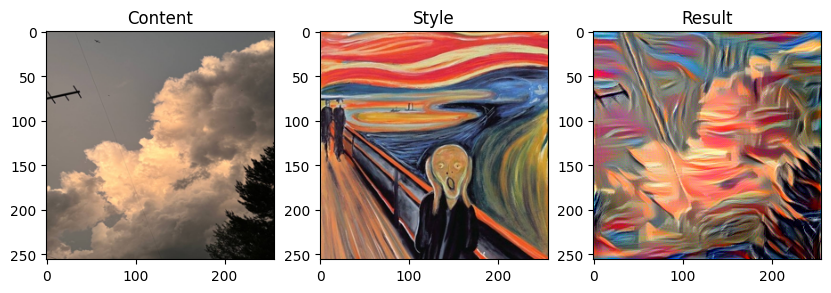

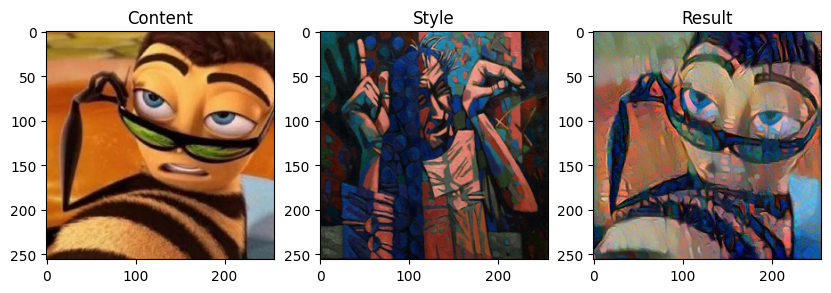

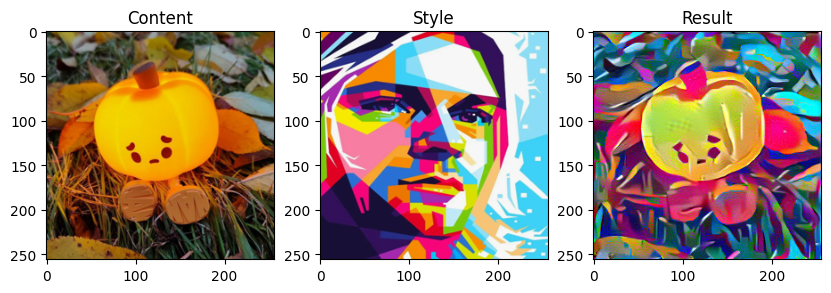

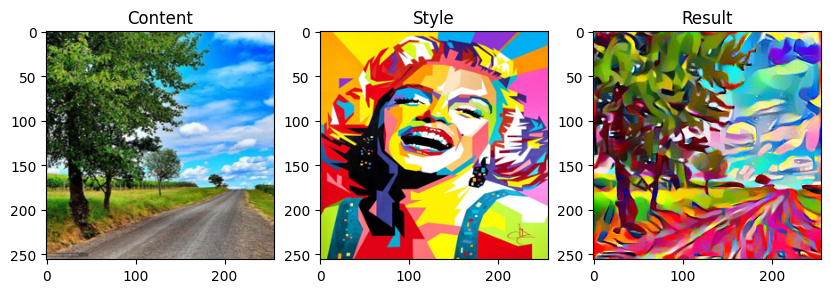

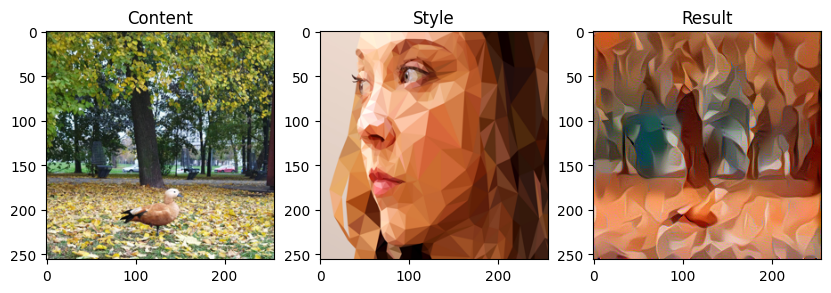

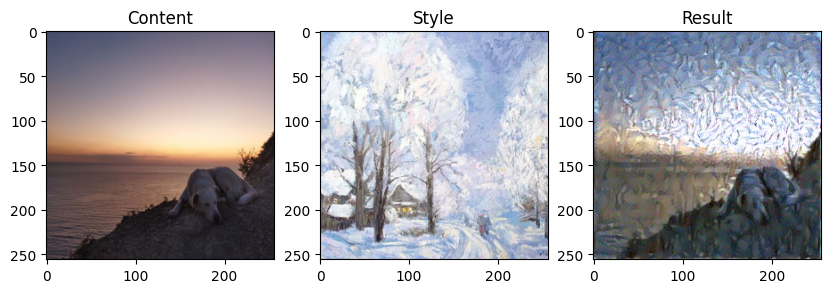

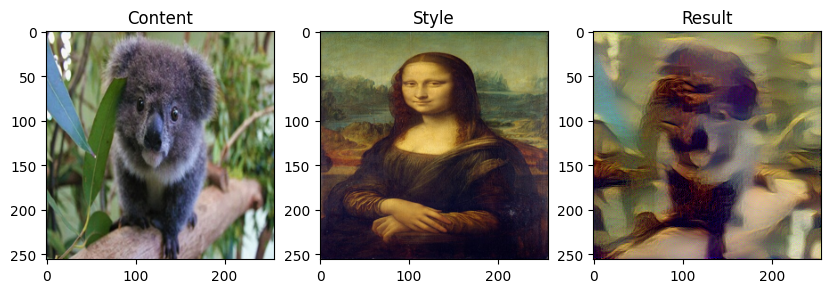

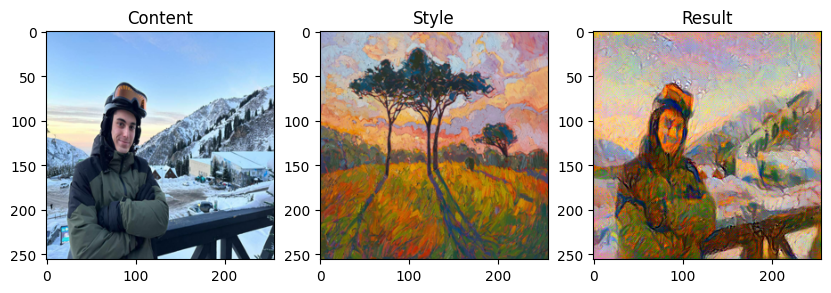

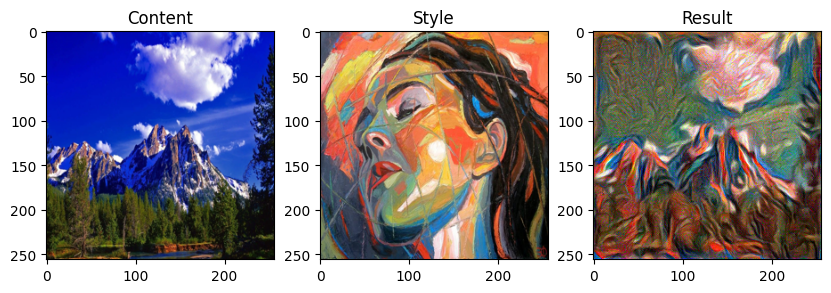

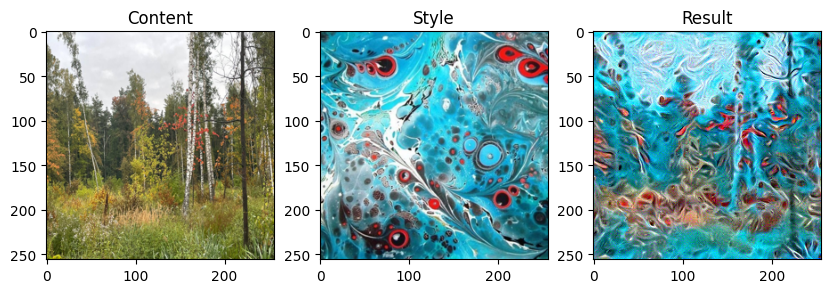

In [17]:
with mlflow.start_run():
    OPTIMIZER = optim.Adam
    LR = 0.05
    NUM_STEPS=300
    CONTENT_WEIGHT = 1
    STYLE_WEIGHT = 10**8
    SCHEDULER_STEP = None
    GAMMA=1.0
    CONTENT_LAYERS = ['Conv_4']
    STYLE_LAYERS = [f'Conv_{i}' for i in range(1, 6)]
    
    params = {
        "IMSIZE": IMSIZE[0],
        "DEVICE": "CPU",
        "VGG-19_layers": 11,
        "optimizer": "Adam",
        "lr": LR,
        "num_steps": NUM_STEPS,
        "content_weight": CONTENT_WEIGHT,
        "style_weight": STYLE_WEIGHT,
        "scheduler_step": "None",
        "scheduler_gamma": "None",
        "content_layers": CONTENT_LAYERS,
        "style_layers": STYLE_LAYERS
    }

    mlflow.log_params(params)

    results = experiment(
        base_model=base_cnn,
        content_images=content_images,
        style_images=style_images,
        optimizer=OPTIMIZER,
        lr=LR,
        num_steps=NUM_STEPS,
        scheduler_step=SCHEDULER_STEP,
        gamma=GAMMA,
        content_weight=CONTENT_WEIGHT,
        style_weight=STYLE_WEIGHT,
        content_layers=CONTENT_LAYERS,
        style_layers=STYLE_LAYERS,
        noisy_input=False,
        print_logs=None
    )

    mlflow.log_metrics(results)

In [18]:
results

{'avg_time': 69.66348707675934,
 'content_score': 0.04146672803908587,
 'style_score': 0.0020456424663279904}